Eksik Veri Sayısı: 0
New features were derived: Approval_Rate_1st, Approval_Rate_2nd, Grade_Change
Target Classes: ['Dropout' 'Graduate']
Class Distribution:
 Target
1    2209
0    1421
Name: count, dtype: int64
CORRELATION ANALYSIS


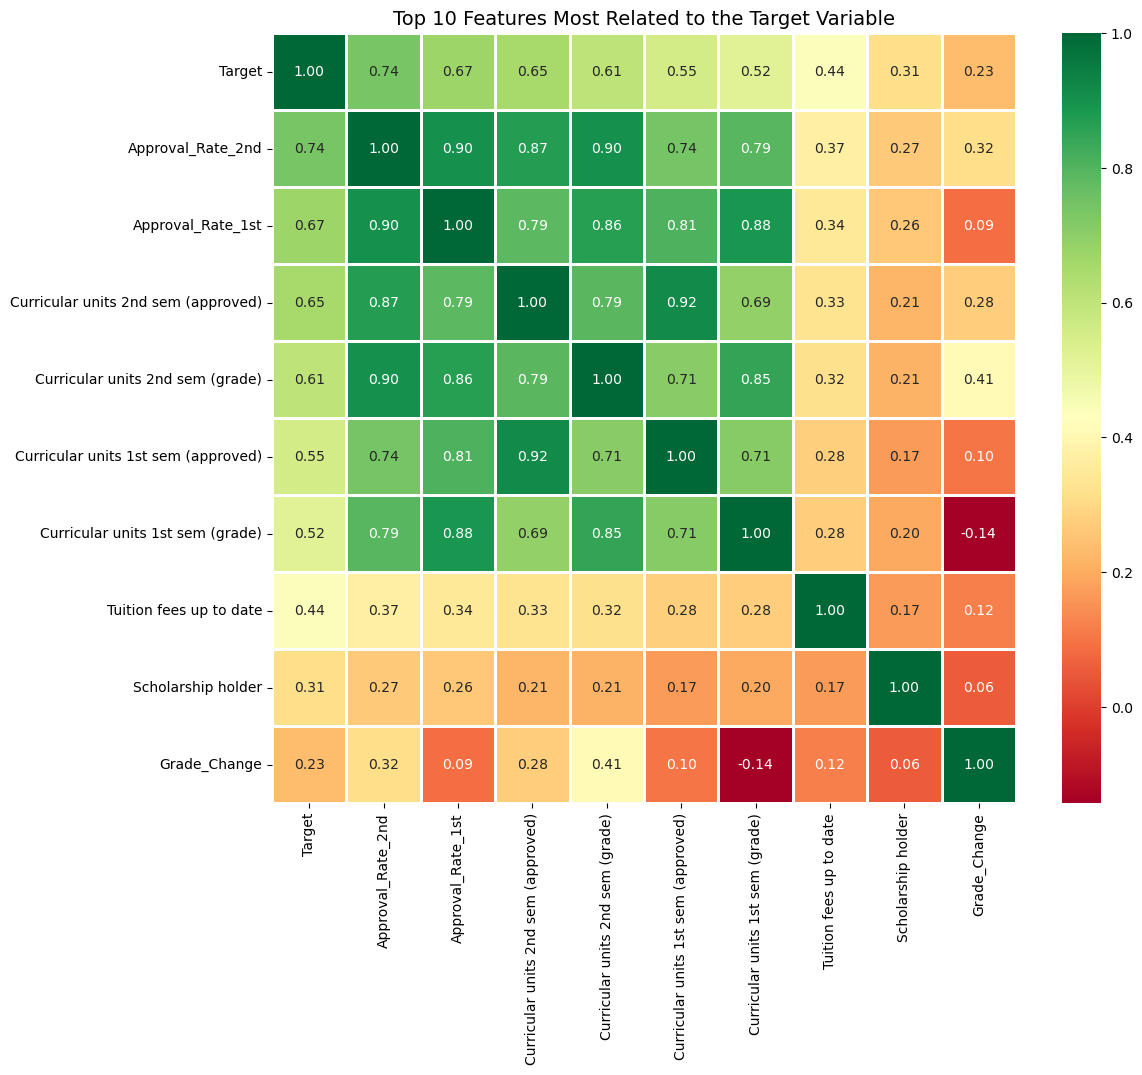

X_train shape: (2904, 39)
X_test shape: (726, 39)
Feature Engineering & PCA


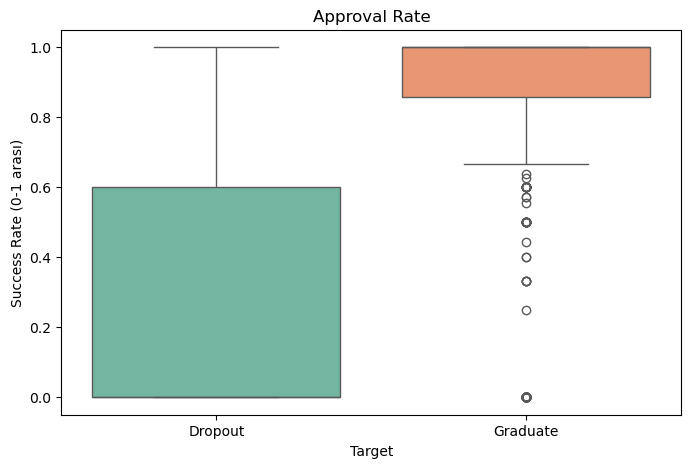

Explained variance ratio: [0.19398064 0.10725544]
Toplam: 0.3012360773247582


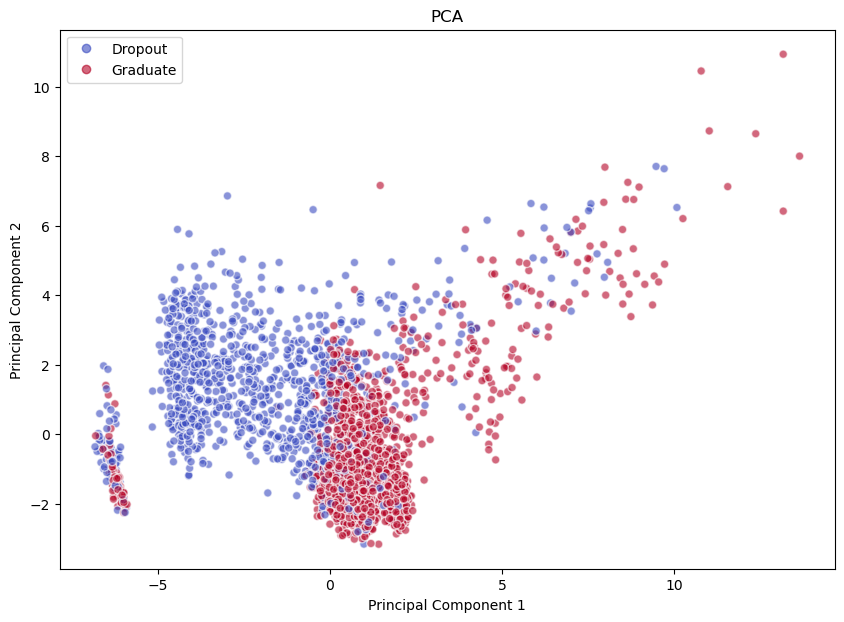


[Baseline] Dummy Classifier Accuracy: 0.6088
Strategy: Always predict the majority class (Graduate).

[Model 1] Gradient Boosting (Trained with Grid Search)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test Accuracy: 0.9160
Test F1 Macro: 0.9099

[Model 2] Random Forest Classifier
Test Accuracy: 0.9174
Test F1 Macro: 0.9109

--- PERFORMANCE SUMMARY ---
Baseline Accuracy : 0.6088
Gradient Boosting : 0.9160
Random Forest     : 0.9174
6.3 DETAILED EVALUATION

--- Champion Model Report (Random Forest) ---
              precision    recall  f1-score   support

     Dropout       0.96      0.83      0.89       284
    Graduate       0.90      0.98      0.93       442

    accuracy                           0.92       726
   macro avg       0.93      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



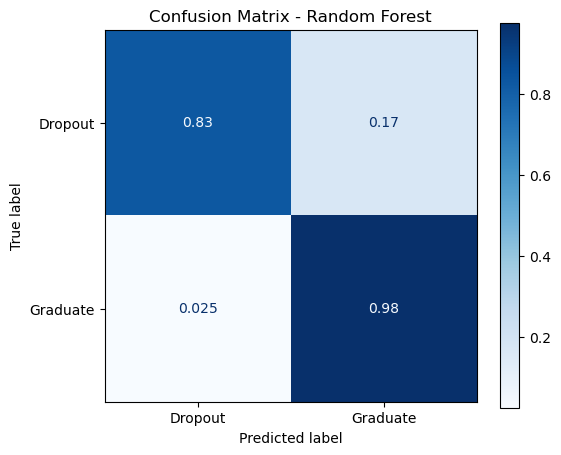

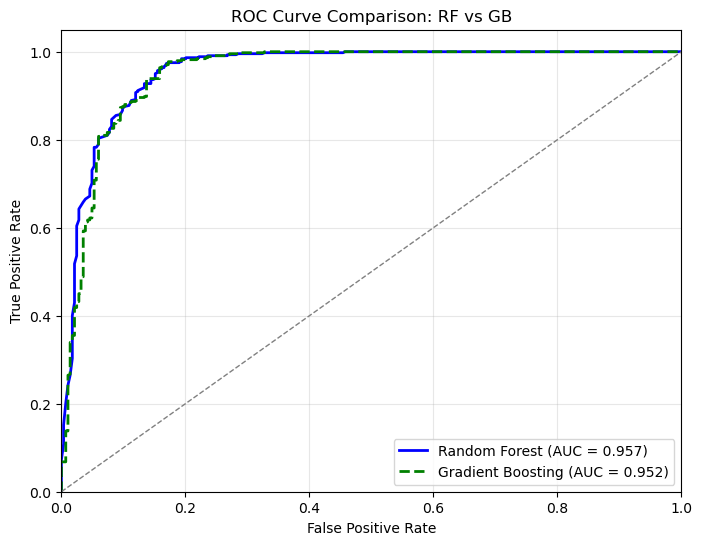

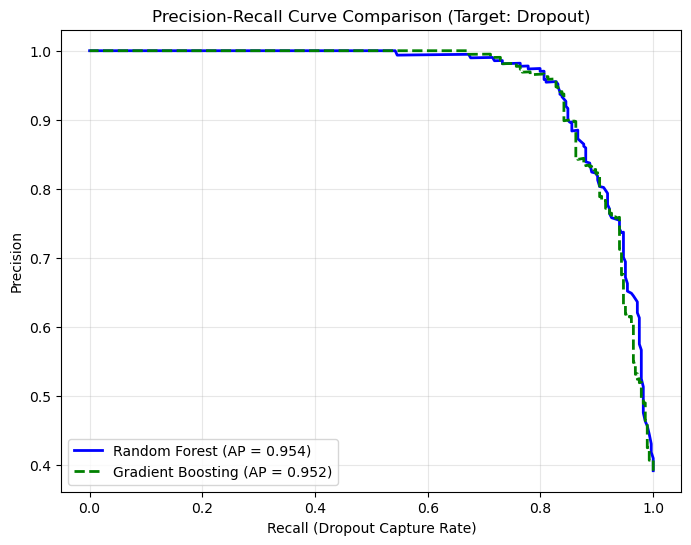


--- ERROR ANALYSIS ---
Toplam 726 test verisinden 60 tanesi yanlış tahmin edildi.

Top 5 Students with Incorrect Predictions (Details):
      Approval_Rate_2nd  Tuition fees up to date  Scholarship holder  Target
4033           0.000000                        1                   0       0
3423           1.000000                        1                   0       0
1761           0.000000                        1                   1       0
2848           0.769231                        1                   0       0
2117           1.000000                        1                   0       0


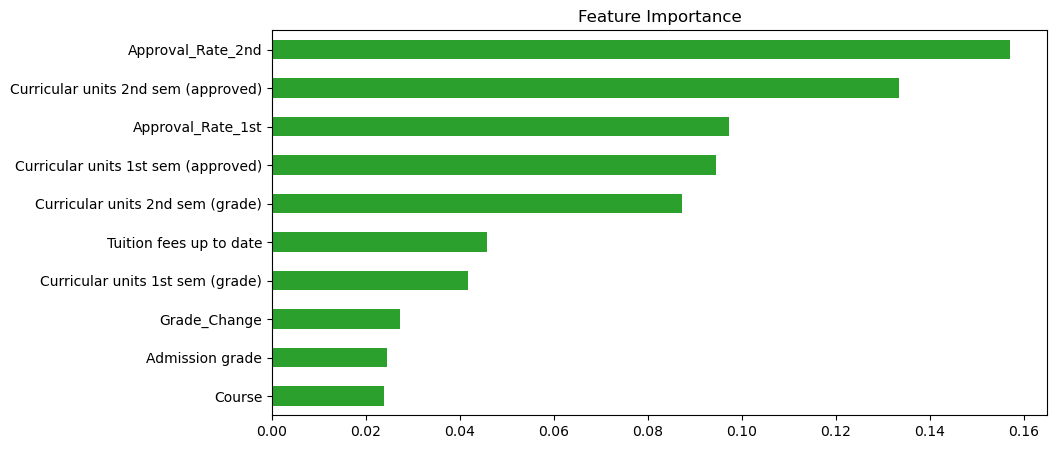

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import precision_recall_curve

# 1. Load the data (Since the delimiter is a semicolon, set sep=‘;’)
df = pd.read_csv('data.csv', sep=';')

# Missing data check (For verification purposes)
print("Eksik Veri Sayısı:", df.isnull().sum().sum())

df = df[df.Target != 'Enrolled']

# Compute semester-wise approval rates and grade change after excluding currently enrolled students
en1 = df['Curricular units 1st sem (enrolled)'].to_numpy()
ap1 = df['Curricular units 1st sem (approved)'].to_numpy()
df['Approval_Rate_1st'] = np.divide(ap1, en1, out=np.zeros_like(ap1, dtype=float), where=en1!=0)

en2 = df['Curricular units 2nd sem (enrolled)'].to_numpy()
ap2 = df['Curricular units 2nd sem (approved)'].to_numpy()
df['Approval_Rate_2nd'] = np.divide(ap2, en2, out=np.zeros_like(ap2, dtype=float), where=en2!=0)

# Grade Change (2nd Term Grade - 1st Term Grade: Is there any improvement?)
df['Grade_Change'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']
print("New features were derived: Approval_Rate_1st, Approval_Rate_2nd, Grade_Change")

# 3. Encoding
# Dropout -> 0, Graduate -> 1 olur (Binary)
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])

# See the classes
print("Target Classes:", le.classes_)
print("Class Distribution:\n", df['Target'].value_counts())

# CORRELATION MATRIX
print("CORRELATION ANALYSIS")

# If we take the correlation of the entire dataset, the graph becomes unreadable (35x35).
# Therefore, we only select the 10 features with the highest correlation with ‘Target’.
k = 10
cols = df.corr().nlargest(k, 'Target')['Target'].index
cm = df[cols].corr()

plt.figure(figsize=(12, 10))
# We print the numbers inside the boxes with Annot=True
sns.heatmap(cm, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=1)
plt.title('Top 10 Features Most Related to the Target Variable', fontsize=14)
plt.show()

# 4. X and Y Separation
y = df['Target']
X = df.drop('Target', axis=1)

# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Scaling (StandardScaler)
scaler = StandardScaler()
# To prevent data leakage, we only ‘fit’ to the train set.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame format (to preserve column names)
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Feature Engineering & PCA")

# 1. Feature Engineering: Boxplot
# Distribution of the newly created ‘Approval_Rate_2nd’ feature by class
plt.figure(figsize=(8, 5))
#We also assign the x variable to the ‘hue’ parameter and turn off the legend.
sns.boxplot(x='Target', y='Approval_Rate_2nd', data=df, hue='Target', legend=False, palette='Set2')
plt.title('Approval Rate')
plt.xticks([0, 1], ['Dropout', 'Graduate'])
plt.ylabel('Success Rate (0-1 arası)')
plt.show()

# 2. PCA 
# Reducing the size from 30+ to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)   
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Toplam:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.6, edgecolors='w')
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Dropout', 'Graduate'])
plt.show()

# A. BASELINE MODEL (Referans Noktası)

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

print(f"\n[Baseline] Dummy Classifier Accuracy: {accuracy_score(y_test, pred_dummy):.4f}")
print("Strategy: Always predict the majority class (Graduate).")

# B. MODEL 1: GRADIENT BOOSTING (with Tuning)
print(f"\n[Model 1] Gradient Boosting (Trained with Grid Search)")

gb = GradientBoostingClassifier(random_state=42)

# Hyperparameter Search 
param_grid = {'n_estimators': [100, 200],'learning_rate': [0.1],
    'max_depth': [3, 4]}

grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid,scoring='f1_macro', 
    cv=cv, n_jobs=-1, verbose=1)

grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
pred_gb = best_gb.predict(X_test)

print(f"Best Params: {grid_gb.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, pred_gb):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, pred_gb, average='macro'):.4f}")

# C. MODEL 2: RANDOM FOREST
print(f"\n[Model 2] Random Forest Classifier")

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, pred_rf):.4f}")
print(f"Test F1 Macro: {f1_score(y_test, pred_rf, average='macro'):.4f}")

# Interpretation
print("\n--- PERFORMANCE SUMMARY ---")
print(f"Baseline Accuracy : {accuracy_score(y_test, pred_dummy):.4f}")
print(f"Gradient Boosting : {accuracy_score(y_test, pred_gb):.4f}")
print(f"Random Forest     : {accuracy_score(y_test, pred_rf):.4f}")

# 6.3 EVALUATION & VISUALIZATION
print("6.3 DETAILED EVALUATION")

# 1. DETAILED REPORT OF THE WINNING MODEL (Random Forest)
print("\n--- Champion Model Report (Random Forest) ---")
print(classification_report(y_test, pred_rf, target_names=['Dropout', 'Graduate']))

# 2. CONFUSION MATRIX (Random Forest)
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=['Dropout', 'Graduate'],
    cmap=plt.cm.Blues, normalize='true', ax=ax)

ax.set_title("Confusion Matrix - Random Forest")
plt.show()

# 3. ROC CURVE COMPARISON (RF vs GB)
# Probability Scores
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

# FPR ve TPR Hesaplama
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_gb, tpr_gb, color='green', linestyle='--', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1) 

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: RF vs GB')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

y_prob_dropout_rf = rf.predict_proba(X_test)[:, 0]
y_prob_dropout_gb = best_gb.predict_proba(X_test)[:, 0]

# Dropout CLass
y_test_dropout = (y_test == 0).astype(int)

precision_rf, recall_rf, _ = precision_recall_curve(y_test_dropout, y_prob_dropout_rf)
precision_gb, recall_gb, _ = precision_recall_curve(y_test_dropout, y_prob_dropout_gb)

ap_rf = average_precision_score(y_test_dropout, y_prob_dropout_rf)
ap_gb = average_precision_score(y_test_dropout, y_prob_dropout_gb)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'Random Forest (AP = {ap_rf:.3f})')
plt.plot(recall_gb, precision_gb, color='green', linestyle='--', lw=2, label=f'Gradient Boosting (AP = {ap_gb:.3f})')
plt.xlabel('Recall (Dropout Capture Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison (Target: Dropout)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. ERROR ANALYSIS 
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred_rf}, index=X_test.index)
errors = results[results['Actual'] != results['Predicted']]
print(f"\n--- ERROR ANALYSIS ---")
print(f"Toplam {len(X_test)} test verisinden {len(errors)} tanesi yanlış tahmin edildi.")
print("\nTop 5 Students with Incorrect Predictions (Details):")
# We look at the critical characteristics of failing students
print(df.loc[errors.index, ['Approval_Rate_2nd', 'Tuition fees up to date', 'Scholarship holder', 'Target']].head())

# 5. FEATURE IMPORTANCE
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_feat = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_feat.plot(kind='barh', color='#2ca02c')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()